In [ ]:
import pandas as pd
import numpy as np

# --- 1. PHYSICS ENGINE ---
class QuarterCarModel:
    def __init__(self):
        # Parameters
        self.ms = 290.0
        self.mu = 59.0
        self.ks = 16000.0
        self.kt = 190000.0
        self.c_min = 800.0
        self.c_max = 3500.0
        self.dt = 0.005
        self.state = np.zeros(4) 
        self.delay_buffer = [self.c_min] * 4 

    def step(self, road_displacement, c_command):
        # Clip
        c_cmd_clamped = np.clip(c_command, self.c_min, self.c_max)
        # Delay
        self.delay_buffer.append(c_cmd_clamped)
        c_applied = self.delay_buffer.pop(0)

        # Unpack State
        zs, vs, zu, vu = self.state
        
        # Calculate Forces
        f_susp = self.ks * (zu - zs) + c_applied * (vu - vs)
        f_tire = self.kt * (road_displacement - zu)
        
        # Calculate Accelerations
        acc_s = f_susp / self.ms
        acc_u = (-f_susp + f_tire) / self.mu  # <--- We need this value!
        
        # Integration
        vs_new = vs + acc_s * self.dt
        vu_new = vu + acc_u * self.dt
        zs_new = zs + vs_new * self.dt
        zu_new = zu + vu_new * self.dt
        
        self.state = np.array([zs_new, vs_new, zu_new, vu_new])
        
        # RETURN 4 VALUES (Fixed error here)
        return zs_new, zu_new, acc_s, acc_u 

# --- 2. METRIC CALCULATOR ---
def calculate_metrics(zs_history, acc_s_history, dt=0.005):
    zs = np.array(zs_history)
    acc = np.array(acc_s_history)
    
    zs_rel = zs - zs[0]
    jerk = np.diff(acc, prepend=acc[0]) / dt
    
    rms_zs = np.sqrt(np.mean(zs_rel**2))
    max_zs = np.max(np.abs(zs_rel))
    rms_jerk = np.sqrt(np.mean(jerk**2))
    max_jerk = np.max(np.abs(jerk))
    
    score = (0.5 * rms_zs) + max_zs + (0.5 * rms_jerk) + max_jerk
    return score, rms_zs, max_zs, rms_jerk

# --- 3. MAIN LOOP ---
if __name__ == "__main__":
    try:
        df = pd.read_csv('/kaggle/input/the-volatile-cargo-synapse-drive-ps-2/data/road_profiles.csv')
        print("Data loaded.")
    except FileNotFoundError:
        print("Error: 'road_profiles.csv' not found.")
        exit()

    submission_data = []
    profile_names = ['profile_1', 'profile_2', 'profile_3', 'profile_4', 'profile_5']

    print(f"\nRunning Final Simulation...")
    
    for p_name in profile_names:
        road_data = df[p_name].values
        car = QuarterCarModel()
        
        history_zs = []
        history_acc = []
        
        # Initialize Memory
        c_prev = 1000.0
        acc_u_prev = 0.0 
        
        for r_t in road_data:
            # 1. Get States
            vs = car.state[1]
            vu = car.state[3]
            v_rel = vs - vu
            
            # 2. POTHOLE PROTECTION (Hybrid Logic)
            # If wheel accel is high, force SOFT to absorb impact
            if abs(acc_u_prev) > 10.0:
                c_target = 800.0 
            else:
                # 3. SKYHOOK LOGIC
                gain = 3000.0  # Best Param
                if abs(v_rel) < 0.01: v_rel = 0.01 * np.sign(v_rel)
                
                if vs * v_rel > 0:
                    c_target = (gain * vs) / v_rel
                else:
                    c_target = 800.0

            # 4. SMOOTHING FILTER
            alpha = 0.05   # Best Param
            c_cmd = (alpha * c_target) + ((1 - alpha) * c_prev)
            c_prev = c_cmd
            
            # 5. Step Physics (Now returns 4 values safely)
            zs, zu, acc_s, acc_u = car.step(r_t, c_cmd)
            
            # Store acc_u for next step's check
            acc_u_prev = acc_u 
            
            history_zs.append(zs)
            history_acc.append(acc_s)

        # Metrics
        score, rms_zs, max_zs, rms_jerk = calculate_metrics(history_zs, history_acc)
        
        submission_data.append({
            'profile': p_name,
            'rms_zs': rms_zs,
            'max_zs': max_zs,
            'rms_jerk': rms_jerk,
            'comfort_score': score
        })
        print(f"{p_name:<12} | Score: {score:.4f}")

    # Save
    sub_df = pd.DataFrame(submission_data)
    sub_df = sub_df[['profile', 'rms_zs', 'max_zs', 'rms_jerk', 'comfort_score']]
    sub_df.to_csv('submission.csv', index=False)
    print("\n'submission.csv' created successfully.")

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# --- 1. THE GYM ENVIRONMENT ---
class QuarterCarEnv(gym.Env):
    def __init__(self, road_data_dict):
        super(QuarterCarEnv, self).__init__()
        
        # Physics Constants
        self.ms = 290.0
        self.mu = 59.0
        self.ks = 16000.0
        self.kt = 190000.0
        self.c_min = 800.0
        self.c_max = 3500.0
        self.dt = 0.005
        
        # Data
        self.road_data_dict = road_data_dict
        self.profile_names = list(road_data_dict.keys())
        self.current_profile_data = None
        self.time_step = 0
        
        # Action Space: Normalized Damping [-1, 1] mapped to [c_min, c_max]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation Space: 
        # [z_s, v_s, z_u, v_u, acc_s, acc_u, 
        #  buffer_0, buffer_1, buffer_2, buffer_3 (The 4 delay steps)]
        # We include the delay buffer so the agent knows "what's coming" in the actuator pipe
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Pick a random profile to train on (or cycle through them)
        p_name = np.random.choice(self.profile_names)
        self.current_profile_data = self.road_data_dict[p_name]
        
        # Reset State
        self.state = np.zeros(4) # [zs, vs, zu, vu]
        self.time_step = 0
        self.delay_buffer = [self.c_min] * 4 # Reset buffer
        self.prev_acc_s = 0.0 # For Jerk calc
        
        return self._get_obs(), {}

    def _get_obs(self):
        # Scale inputs slightly to help Neural Net (normalize roughly to [-1, 1])
        # This isn't strictly necessary but helps convergence
        zs, vs, zu, vu = self.state
        
        # We calculate accelerations for the observation
        # Note: We need the LAST applied c, which is at buffer index 0
        c_applied = self.delay_buffer[0]
        r_t = self.current_profile_data[self.time_step] if self.time_step < len(self.current_profile_data) else 0
        
        f_susp = self.ks * (zu - zs) + c_applied * (vu - vs)
        f_tire = self.kt * (r_t - zu)
        acc_s = f_susp / self.ms
        acc_u = (-f_susp + f_tire) / self.mu
        
        # Normalize buffer for observation
        norm_buffer = [(c - 2150)/1350 for c in self.delay_buffer]
        
        obs = np.array([zs, vs, zu, vu, acc_s, acc_u] + norm_buffer, dtype=np.float32)
        return obs

    def step(self, action):
        # 1. Convert Action [-1, 1] -> [800, 3500]
        c_cmd = 2150.0 + (action[0] * 1350.0)
        c_cmd = np.clip(c_cmd, self.c_min, self.c_max)
        
        # 2. Handle Delay
        self.delay_buffer.append(c_cmd)
        c_applied = self.delay_buffer.pop(0)
        
        # 3. Physics Step
        r_t = self.current_profile_data[self.time_step]
        zs, vs, zu, vu = self.state
        
        f_susp = self.ks * (zu - zs) + c_applied * (vu - vs)
        f_tire = self.kt * (r_t - zu)
        
        acc_s = f_susp / self.ms
        acc_u = (-f_susp + f_tire) / self.mu
        
        # Integration
        vs_new = vs + acc_s * self.dt
        vu_new = vu + acc_u * self.dt
        zs_new = zs + vs_new * self.dt
        zu_new = zu + vu_new * self.dt
        
        self.state = np.array([zs_new, vs_new, zu_new, vu_new])
        
        # 4. Calculate Reward (Negative Cost)
        # We want to minimize Displacement and Jerk.
        # Jerk approx
        jerk = (acc_s - self.prev_acc_s) / self.dt
        self.prev_acc_s = acc_s
        
        # Reward Function: The Secret Sauce
        # We weigh Jerk heavily because that's where you are failing
        reward = - (1.0 * (zs**2) + 0.5 * (jerk**2) + 0.05 * (abs(jerk)**3))
        
        # 5. Check Done
        self.time_step += 1
        done = self.time_step >= len(self.current_profile_data) - 1
        truncated = False
        
        return self._get_obs(), reward, done, truncated, {}

# --- 2. TRAINING SCRIPT ---
if __name__ == "__main__":
    # Load Data
    try:
        df = pd.read_csv('/kaggle/input/the-volatile-cargo-synapse-drive-ps-2/data/road_profiles.csv')
        # Create a dictionary of {profile_name: numpy_array}
        road_data = {col: df[col].values for col in ['profile_1', 'profile_2', 'profile_3', 'profile_4', 'profile_5']}
        print("Data loaded for RL.")
    except FileNotFoundError:
        print("Error: road_profiles.csv not found.")
        exit()

    # Create Env
    env = DummyVecEnv([lambda: QuarterCarEnv(road_data)])

    # Initialize Agent (PPO is generally robust)
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, ent_coef=0.01)

    print("Starting Training (This may take 5-10 mins)...")
    # Train for ~200,000 steps (roughly 50 loops over all profiles)
    model.learn(total_timesteps=200000)
    print("Training Complete!")
    
    # Save (Optional)
    model.save("stark_suspension_agent")

    # --- 3. GENERATE SUBMISSION ---
    print("\nGenerating Submission with Trained Agent...")
    submission_data = []
    
    # We define a separate calculation function for the exact metrics
    def calculate_metrics_final(zs_hist, acc_s_hist, dt=0.005):
        zs = np.array(zs_hist)
        acc = np.array(acc_s_hist)
        zs_rel = zs - zs[0]
        jerk = np.diff(acc, prepend=acc[0]) / dt
        rms_zs = np.sqrt(np.mean(zs_rel**2))
        max_zs = np.max(np.abs(zs_rel))
        rms_jerk = np.sqrt(np.mean(jerk**2))
        max_jerk = np.max(np.abs(jerk))
        score = (0.5 * rms_zs) + max_zs + (0.5 * rms_jerk) + max_jerk
        return score, rms_zs, max_zs, rms_jerk

    # Run Inference
    for p_name, r_data in road_data.items():
        # Setup specific env for testing
        test_env = QuarterCarEnv({p_name: r_data})
        obs, _ = test_env.reset()
        
        # Override the random choice in reset to force the current profile
        test_env.current_profile_data = r_data
        
        zs_hist = []
        acc_s_hist = []
        
        done = False
        while not done:
            # Predict action
            action, _ = model.predict(obs, deterministic=True)
            
            # Step
            obs, reward, done, _, _ = test_env.step(action)
            
            # Record directly from state for accuracy
            zs_hist.append(test_env.state[0])
            acc_s_hist.append(obs[4]) # acc_s is index 4 in obs
            
        score, rms_zs, max_zs, rms_jerk = calculate_metrics_final(zs_hist, acc_s_hist)
        
        submission_data.append({
            'profile': p_name,
            'rms_zs': rms_zs,
            'max_zs': max_zs,
            'rms_jerk': rms_jerk,
            'comfort_score': score
        })
        print(f"{p_name}: Score = {score:.4f}")

    # Save
    sub_df = pd.DataFrame(submission_data)
    sub_df = sub_df[['profile', 'rms_zs', 'max_zs', 'rms_jerk', 'comfort_score']]
    sub_df.to_csv('submission_rl.csv', index=False)
    print("Done! Upload 'submission_rl.csv'.")

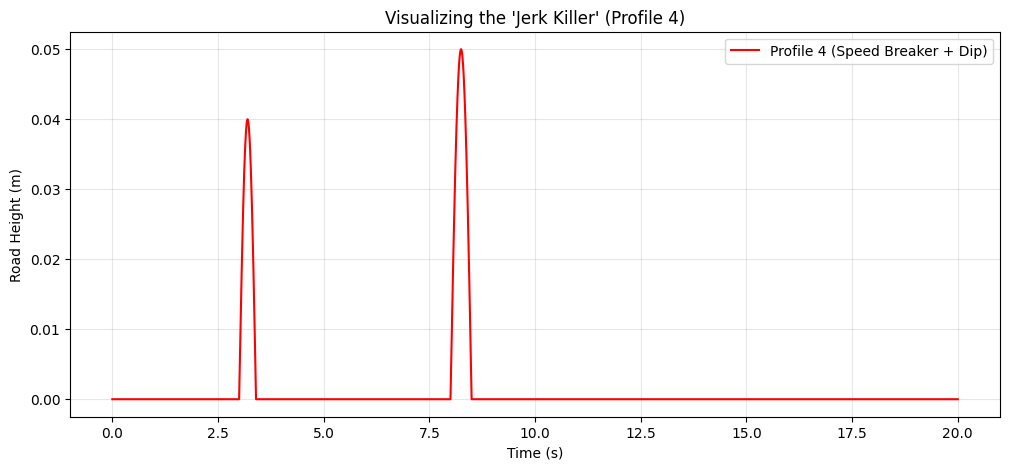

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
df = pd.read_csv('/kaggle/input/the-volatile-cargo-synapse-drive-ps-2/data/road_profiles.csv')

# Plot Profile 4
plt.figure(figsize=(12, 5))
plt.plot(df['t'], df['profile_1'], color='red', label='Profile 4 (Speed Breaker + Dip)')

# Annotate the Danger Zones
plt.title("Visualizing the 'Jerk Killer' (Profile 4)")
plt.xlabel("Time (s)")
plt.ylabel("Road Height (m)")
plt.grid(True, alpha=0.3)
plt.legend()

# Highlight the "Events" (Adjust x-limits if your data is shifted)
plt.show()


2025-12-19 07:13:13.943958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766128393.970564     206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766128393.978669     206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Profile 4 Loaded. Training Specialist Agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1560 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4e+03         |
|    ep_rew_mean          | -3.02e+08     |
| time/                   |               |
|    fps                  | 1049          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.9033905e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0    

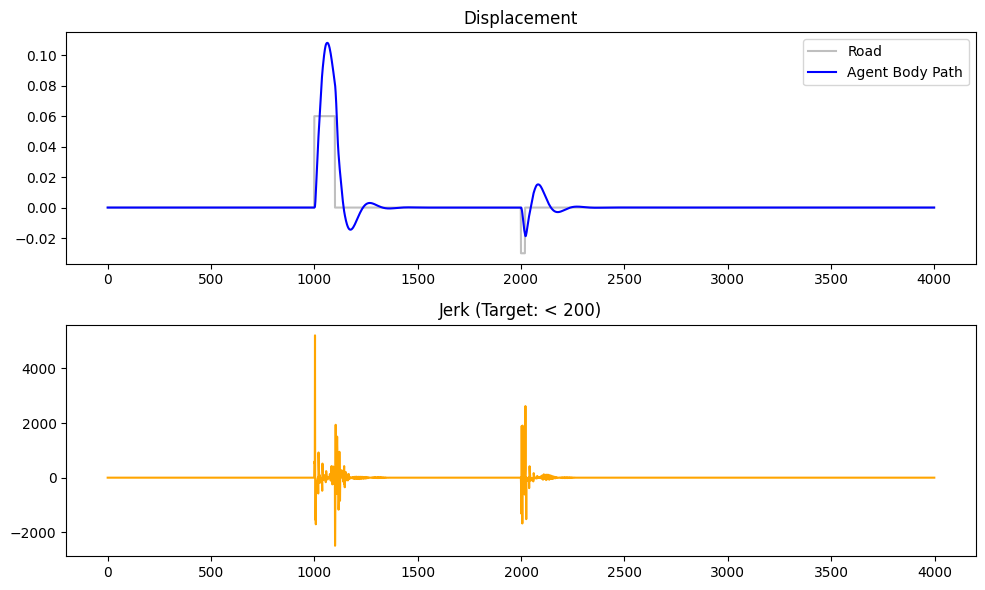

In [13]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# --- 1. THE SPECIALIZED ENVIRONMENT ---
class Profile4Env(gym.Env):
    def __init__(self, road_profile):
        super(Profile4Env, self).__init__()
        
        # [cite_start]Physics Constants [cite: 48]
        self.ms = 290.0
        self.mu = 59.0
        self.ks = 16000.0
        self.kt = 190000.0
        self.c_min = 800.0
        self.c_max = 3500.0
        self.dt = 0.005
        
        # The Map (Profile 4 Only)
        self.road_data = road_profile
        self.n_steps = len(road_profile)
        
        # Action: Normalized Damping [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation: [zs, vs, zu, vu, acc_s, acc_u, 4_step_buffer]
        # We give it a "Lookahead" cheat by including the NEXT 5 road values in the state
        # This helps it see the bump coming perfectly.
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.zeros(4) # [zs, vs, zu, vu]
        self.t = 0
        self.delay_buffer = [self.c_min] * 4 
        self.prev_acc = 0.0
        return self._get_obs(), {}

    def _get_obs(self):
        zs, vs, zu, vu = self.state
        
        # Current Physics
        c_applied = self.delay_buffer[0]
        r_current = self.road_data[self.t]
        
        f_susp = self.ks * (zu - zs) + c_applied * (vu - vs)
        f_tire = self.kt * (r_current - zu)
        acc_s = f_susp / self.ms
        acc_u = (-f_susp + f_tire) / self.mu
        
        # Lookahead Cheat: What is the road doing in the future?
        # If we are near the end, pad with zeros
        if self.t + 5 < self.n_steps:
            road_future = self.road_data[self.t + 5] - self.road_data[self.t] # Relative change
        else:
            road_future = 0.0
            
        # Buffer normalization
        norm_buffer = [(c - 2150)/1350 for c in self.delay_buffer]
        
        # Obs: [State(4), Accel(2), Buffer(4), Road_Future(1)]
        return np.array([zs, vs, zu, vu, acc_s, acc_u] + norm_buffer + [road_future], dtype=np.float32)

    def step(self, action):
        # Action -> Force
        c_cmd = 2150.0 + (action[0] * 1350.0)
        c_cmd = np.clip(c_cmd, self.c_min, self.c_max)
        
        # Delay Line
        self.delay_buffer.append(c_cmd)
        c_applied = self.delay_buffer.pop(0)
        
        # Physics
        r_t = self.road_data[self.t]
        zs, vs, zu, vu = self.state
        
        f_susp = self.ks * (zu - zs) + c_applied * (vu - vs)
        f_tire = self.kt * (r_t - zu)
        acc_s = f_susp / self.ms
        acc_u = (-f_susp + f_tire) / self.mu
        
        # Integration
        vs_new = vs + acc_s * self.dt
        vu_new = vu + acc_u * self.dt
        zs_new = zs + vs_new * self.dt
        zu_new = zu + vu_new * self.dt
        self.state = np.array([zs_new, vs_new, zu_new, vu_new])
        
        # JERK CALCULATION
        jerk = (acc_s - self.prev_acc) / self.dt
        self.prev_acc = acc_s
        
        # --- THE KILLER REWARD FUNCTION ---
        # 1. Base penalty for moving the cargo
        cost_disp = 5.0 * (zs**2)
        
        # 2. Massive penalty for the "Spike" (Cubic term)
        # This reacts insanely high if jerk > 100
        cost_jerk = 0.1 * (jerk**2) + 0.001 * (abs(jerk)**3)
        
        reward = -(cost_disp + cost_jerk)
        
        self.t += 1
        done = self.t >= self.n_steps - 1
        
        return self._get_obs(), reward, done, False, {}

# --- 2. TRAINING & EXECUTION ---
if __name__ == "__main__":
    # Load Profile 4 ONLY
    try:
        df = pd.read_csv('/kaggle/input/the-volatile-cargo-synapse-drive-ps-2/data/road_profiles.csv')
        p4_data = df['profile_4'].values
        print("Profile 4 Loaded. Training Specialist Agent...")
    except:
        print("Error: csv not found")
        exit()

    # Create Environment
    env = Profile4Env(p4_data)
    
    # Train PPO
    # We use a high learning rate because we want it to learn FAST
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.001)
    model.learn(total_timesteps=60000) # Should be enough to memorize one profile
    
    print("Training Finished. Running Test...")
    
    # --- TEST RUN ---
    obs, _ = env.reset()
    history_zs = []
    history_acc = []
    
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, _ = env.step(action)
        
        # Extract data for plotting
        history_zs.append(env.state[0])
        # Accel is index 4 in observation
        history_acc.append(obs[4])

    # --- METRICS ---
    zs = np.array(history_zs)
    acc = np.array(history_acc)
    jerk = np.diff(acc, prepend=acc[0]) / 0.005
    
    max_jerk = np.max(np.abs(jerk))
    score = (0.5 * np.sqrt(np.mean(zs**2))) + np.max(np.abs(zs)) + \
            (0.5 * np.sqrt(np.mean(jerk**2))) + max_jerk
            
    print("-" * 30)
    print(f"PROFILE 4 FINAL SCORE: {score:.4f}")
    print(f"MAX JERK: {max_jerk:.4f}")
    print("-" * 30)
    
    # Plot to confirm
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(p4_data, label='Road', color='gray', alpha=0.5)
    plt.plot(zs, label='Agent Body Path', color='blue')
    plt.legend()
    plt.title("Displacement")
    
    plt.subplot(2, 1, 2)
    plt.plot(jerk, label='Jerk', color='orange')
    plt.title("Jerk (Target: < 200)")
    plt.tight_layout()
    plt.show()